# PyCallでSeabornをRubyから使うためのプロットカタログ
## Seaborn plots catalog by PyCall/Ruby

[Seaborn](https://seaborn.pydata.org/)のプロットの種類と実例を、[PyCall](https://github.com/mrkn/pycall.rb)を使ってRubyから使う形でまとめました。元々はPythonで自分用に作っていたNotebookでしたが、PyCallを利用してRubyで十分動かせることがわかり、途中からRuby版に移行して完成させました。

[Seabornの公式APIリファレンス](https://seaborn.pydata.org/api.html) にあるリストに概ね従って記述していきますが、簡単なものから複雑なものとなるように、また、より一般化されたものが後に来るように工夫します。

![Image](https://seaborn.pydata.org/_images/function_overview_8_0.png)

(https://seaborn.pydata.org/tutorial/function_overview.html#figure-level-vs-axes-level-functions より)

### 使用するライブラリの読み込み

In [73]:
RUBY_DESCRIPTION 

"ruby 3.0.2p107 (2021-07-07 revision 0db68f0233) [x86_64-linux]"

In [1]:
require 'pycall'
PyCall::VERSION

"1.4.1"

In [2]:
require 'numpy'
np = Numpy
np.__version__

"1.22.3"

In [3]:
require 'matplotlib'
require 'matplotlib/iruby'
Matplotlib::IRuby.activate
plt = Matplotlib::pyplot
Matplotlib.__version__

"3.5.1"

In [4]:
sns = PyCall.import_module('seaborn')
sns.__version__

"0.11.2"

例題となるデータをデータ名に対応する変数に読み込みます。

In [104]:
anscombe = sns.load_dataset('anscombe')
attention = sns.load_dataset('attention')
exercise = sns.load_dataset('exercise')
flights = sns.load_dataset('flights')
fmri = sns.load_dataset('fmri')
geyser = sns.load_dataset('geyser')
iris = sns.load_dataset('iris')
penguins = sns.load_dataset('penguins')
planets = sns.load_dataset('planets')
tips = sns.load_dataset('tips')
titanic = sns.load_dataset('titanic')
sns.get_dataset_names

['anagrams', 'anscombe', 'attention', 'brain_networks', 'car_crashes', 'diamonds', 'dots', 'exercise', 'flights', 'fmri', 'gammas', 'geyser', 'iris', 'mpg', 'penguins', 'planets', 'taxis', 'tips', 'titanic']

ここで使っているスタイルは、私の好みで下記のようにしています。
* Figure levelのオブジェクトは`g`に代入し、Axes levelのオブジェクトは`ax`に代入します。どちらのオブジェクトか意識するためです。
* 可能な限りキーワード引数で明示して使いつつ、ポジションも大事にします。キーワード引数は`data`が最初、続いて`kind`(ある場合)、次が`x`, `y`、さらに3番目以降の変数(`hue`や`col`, `row`)を並べます。色指定は`hue`に近接して書きます。
* キーワードはハッシュっぽく書き、値は一重引用符で括って続けて書きます。例：`x:'month'` や `style:'whitegrid'`。シンボルを使って`x: :month`とも書けますがカタマリ感があってすっきりしている前者のようにしています。
* メソッドチェーンが可能な場合はなるべく使います。
* 文字列は、シンボルでも表せる場合は一重引用符で括り、Pythonに渡して使われる場合や空白を含む場合、式展開が行われる場合は二重引用符としています。


## Relational plots

### scatterplot

- 2変数の関係を散布図で示す
- Axesレベルのインターフェース
- [seaborn API reference: scatterplot](https://seaborn.pydata.org/generated/seaborn.scatterplot.html#seaborn.scatterplot)

<AxesSubplot:title={'center':'Tips'}, xlabel='total_bill', ylabel='tip'>

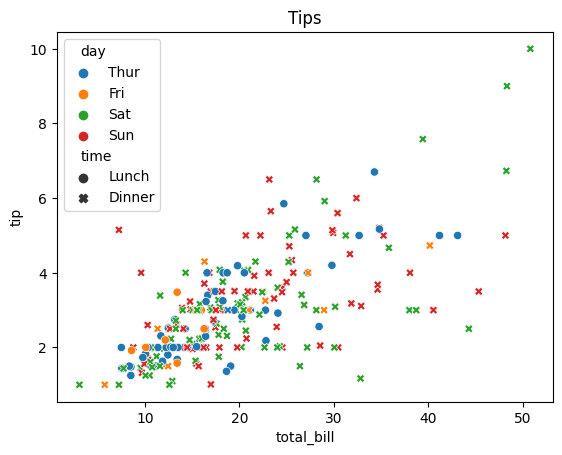

In [9]:
ax = sns.scatterplot(
  data:tips,
  x:'total_bill',
  y:'tip',
  hue:'day', # 3番目の変数
  style:'time', # 4番目の変数
)
ax.set_title("Tips")
ax

### lineplot

- 2変数の関係を、データ順に線で結んだ散布図で示す
- Axesレベルのインターフェース
- [seaborn API reference: lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot)

<AxesSubplot:title={'center':'fMRI analyses'}, xlabel='timepoint', ylabel='signal'>

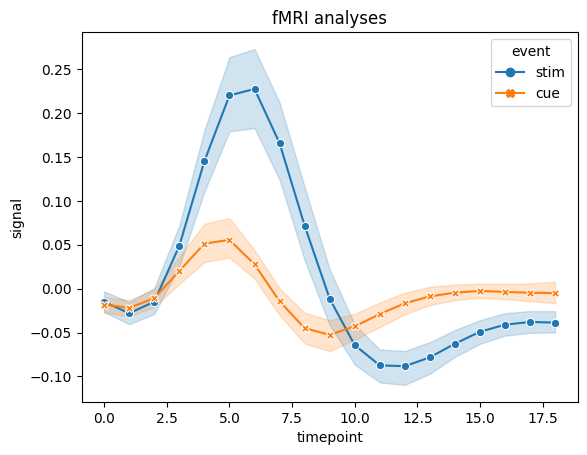

In [15]:
ax = sns.lineplot(
  data: fmri,
  x:'timepoint', y:'signal',
  hue:'event', style:'event',
  markers:true,
  dashes:false
)
ax.set_title("fMRI analyses")
ax

### relplot (Figure level)

- 2変数の関係を示すためのより一般的なプロット
- Figureレベルのインターフェース

kind: 'scatter'(既定値)でscatterplot、kind: 'line'でlineplotとほぼ同じ見た目を提供するが、少し異なっている。

|      |scatterplot<br>lineplot|  relplot  |
| :--- |:---- | :---- |
| Returns | AxesSubplot<br>(matplotlib) |  FacetGrid<br>(seaborn)  |
|Spine<br>軸以外の枠線|デフォルトで表示する|デフォルトでは表示しない<br>sns.despineで制御|
| Legend<br>凡例 | サブプロットの中 |サブプロットの中には書かず、<br>Figureの外に置く|

- [seaborn API reference: relplot](https://seaborn.pydata.org/generated/seaborn.relplot.html)
- [seaborn relplot tutorial](https://seaborn.pydata.org/tutorial/relational.html#relational-tutorial)

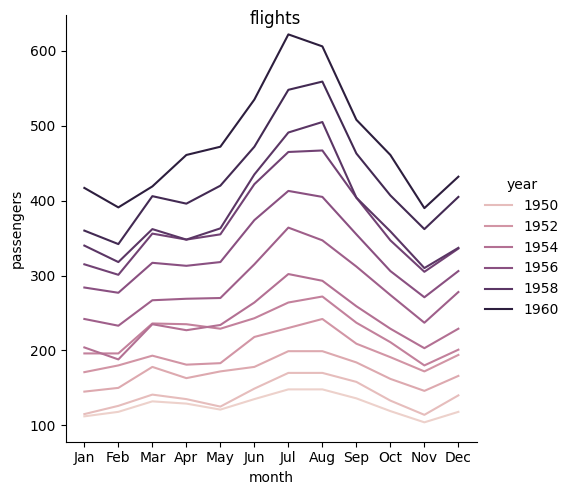

In [17]:
g = sns.relplot(
  data:flights, kind:'line',
  x:'month', y:'passengers',
  hue:'year',
)
g.fig.suptitle("flights")
g

マーカーをx(横軸)とy(縦軸)で表される平面にプロットしてその関係を表示するのが基本だが、hue(マーカーの色), size(マーカーの大きさ), style(マーカーの形状)を使って別の軸を同時に図示することができる。hueとstyleが同じ軸を参照するようにして可読性を高めることもよく行われる。Figureレベルの関数なので、下記のように変数(`day`,`time`)毎のfacetを(横,縦)に並べて表示することができる。

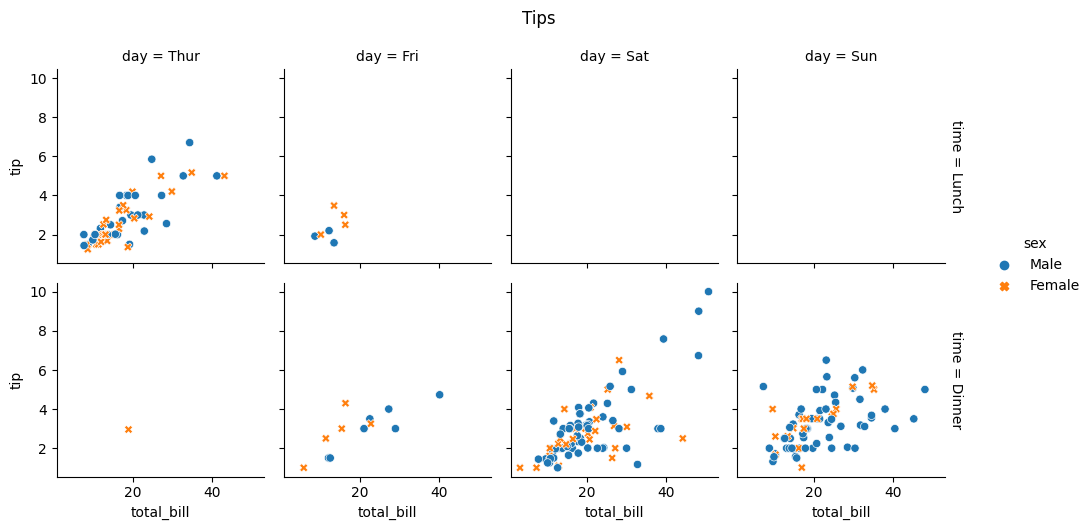

In [18]:
g = sns.relplot(
  data: tips,
  x:'total_bill', y:'tip',
  hue:'sex', style:'sex',
  col:'day', row:'time',
  height:2.5,
  facet_kws:{margin_titles:true},
)
g.fig.suptitle("Tips", y:1.05)
g

##### relplotチートシート

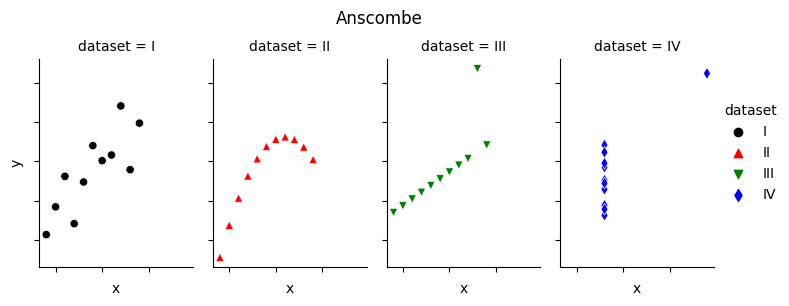

In [21]:
g = sns.relplot( # Figure level interface to show relationship between 2-vars.
  data:anscombe,  # pandas.DataFrame, numpy.ndarray, mapping, or sequence
  x:'x', y:'y',   # vectors or keys in data
  hue:'dataset', size:nil, style:'dataset',   # vectors or keys in data
  col:'dataset', row:nil,    # vectors or keys in data
  palette:%w[k r g b],  # sns.color_palette('husl', int), sns.color_palette("Set2"), etc.
  hue_order:nil, hue_norm:nil,
  sizes:nil, size_order:nil, size_norm:nil,
  dashes:nil, markers:%w[o ^ v d], style_order:nil,
  col_wrap:nil, row_order:nil, col_order:nil,
  legend:'auto',  # 'auto', 'brief', 'full', 'false'
  height:3, aspect:5/8.0,  # size of facet, aspect=width/height
  facet_kws:nil,  # {sharex: nil} : do not share x-axis
                  # {margin_titles: true} : place (col,row) title at top and left
  units:nil,
  kind:'scatter', # 'scatter', 'line'
) # Returns FacetGrid
g.fig.suptitle("Anscombe", y:1.05)   # Specify FacetGrid Title
g.set(xticklabels: "", yticklabels: "")
g

## Distribution plots

### histplot

- 1変数または2変数の分布をヒストグラムで示す
- Axesレベルのインターフェース
- [seaborn API reference: histplot](https://seaborn.pydata.org/generated/seaborn.histplot.html#seaborn.histplot)

<AxesSubplot:xlabel='flipper_length_mm', ylabel='Count'>

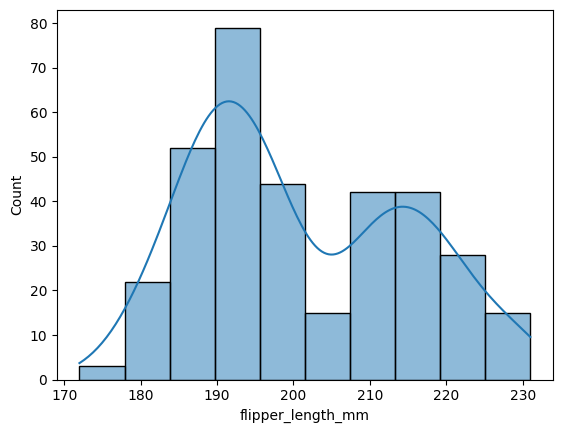

In [24]:
ax = sns.histplot(data:penguins, x:'flipper_length_mm', kde:true)

主なパラメータ:
- `binwidth`         : ビン幅を規定
- `bins`             : ビン数を規定
- `kde:true`         : 分布をスムージングした kernel density estimate(KDE)を重ねて描画
- `multiple:'stack'` : 複数の分布がある場合に積み上げて描画
- `element:'step'`   : 階段状に繋げて表示
- `fill:false`       : 塗りつぶしを行わない
- `stat:'density'`   : 度数軸を密度で表示する
- `log_scale:true`   : bin軸を対数で表示する

<AxesSubplot:xlabel='distance', ylabel='Density'>

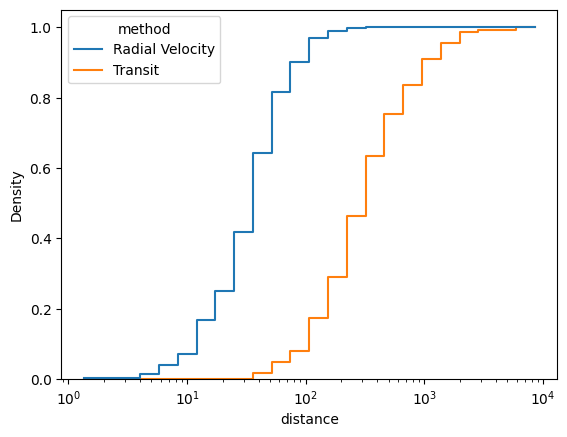

In [27]:
ax = sns.histplot(
  data:planets,
  x:'distance', hue:'method',
  hue_order:['Radial Velocity', 'Transit'],
  log_scale:true, element:'step', fill:false,
  cumulative:true, stat:'density', common_norm:false,
)

xとyが両方指定された場合には、ヒートマップで表示する。

<AxesSubplot:xlabel='bill_depth_mm', ylabel='body_mass_g'>

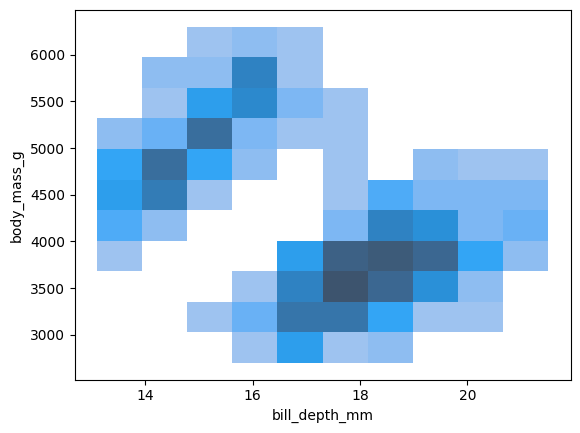

In [28]:
ax = sns.histplot(data:penguins, x:'bill_depth_mm', y:'body_mass_g')

xかyの片方がカテゴリー変数になっている場合に、カラーマップヒストグラムは有効。

<AxesSubplot:xlabel='bill_depth_mm', ylabel='species'>

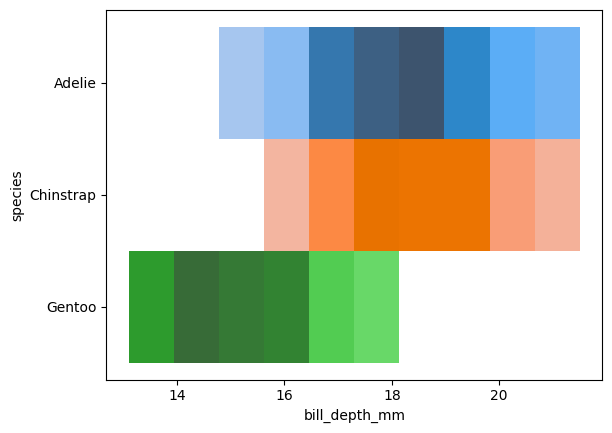

In [29]:
ax = sns.histplot(
  data:penguins, x:'bill_depth_mm', y:'species', hue:'species', legend:false)

カテゴリー変数、対数、カラーバーを使用する例

<AxesSubplot:xlabel='year', ylabel='distance'>

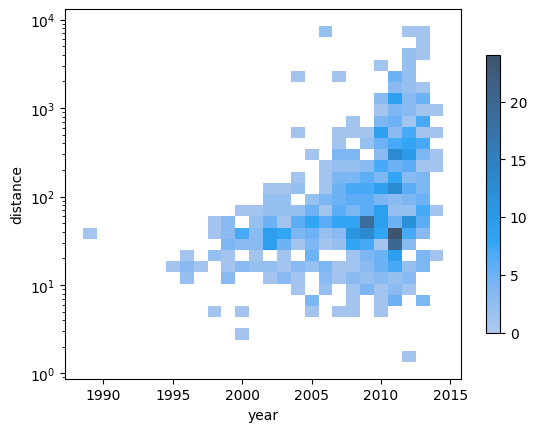

In [30]:
ax = sns.histplot(
  data:planets,
  x:'year', y:'distance',
  bins:30, discrete:[true, false], log_scale:[false, true],
  cbar:true, cbar_kws:{shrink:0.75},
)

### kdeplot

- 1変数または2変数の分布をなめらかな線で示す
- KDE=kernel density estimate
- Axesレベルのインターフェース
- [seaborn API reference: kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot)

<AxesSubplot:ylabel='Density'>

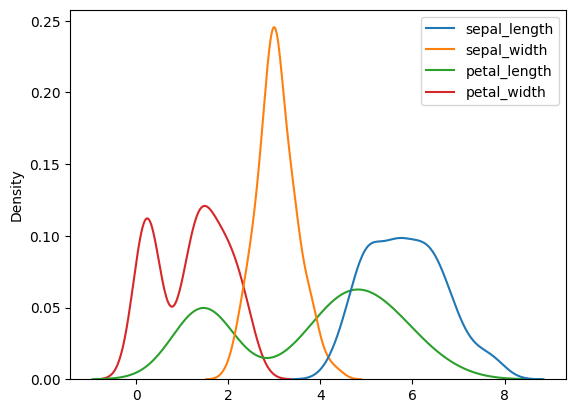

In [37]:
ax = sns.kdeplot(data:iris)

`histplot`とほぼ同じパラメータをとる。また下記のようにすると密度分布を表す。

<AxesSubplot:xlabel='total_bill', ylabel='Density'>

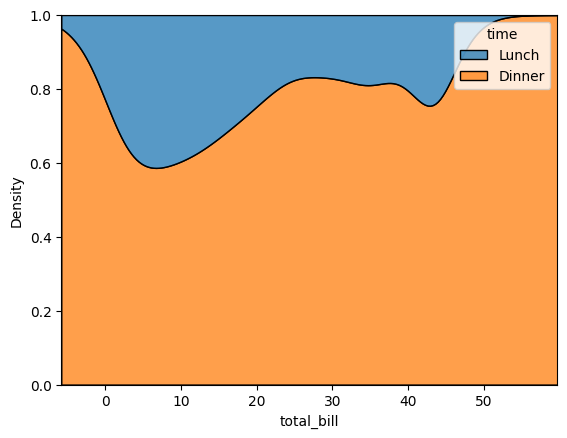

In [38]:
ax = sns.kdeplot(data:tips, x:'total_bill', hue:'time', multiple:'fill')

2変数の場合の例。塗りつぶし等高線で表現している。

<AxesSubplot:xlabel='waiting', ylabel='duration'>

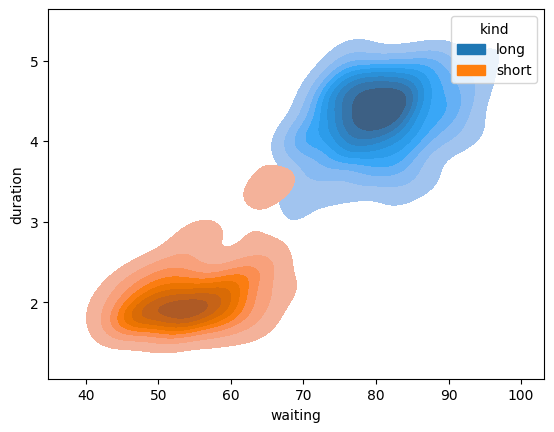

In [41]:
ax = sns.kdeplot(data:geyser, x:'waiting', y:'duration', hue:'kind', fill:true)

### ecdfplot

- 経験累積分布関数(Empirical cumulative distribution functions)をプロットする
- Axesレベルのインターフェース
- [seaborn API reference: ecdfplot](https://seaborn.pydata.org/generated/seaborn.ecdfplot.html#seaborn.ecdfplot)

<AxesSubplot:xlabel='flipper_length_mm', ylabel='Proportion'>

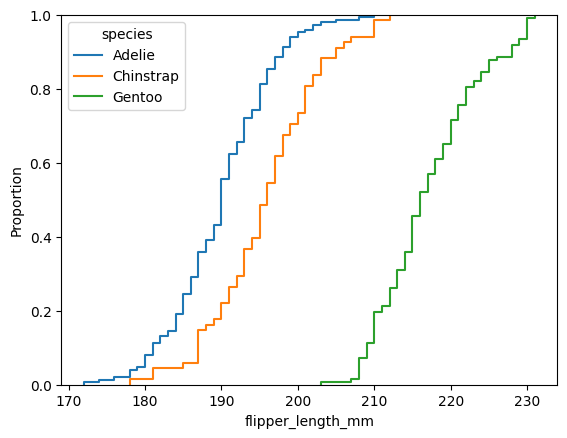

In [42]:
ax = sns.ecdfplot(data:penguins, x:'flipper_length_mm', hue:'species')

<AxesSubplot:xlabel='flipper_length_mm', ylabel='Count'>

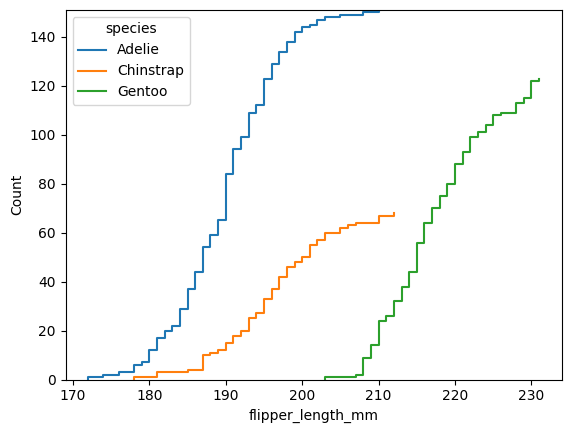

In [43]:
ax = sns.ecdfplot(data:penguins, x:'flipper_length_mm', hue:'species', stat:'count')

### rugplot

- x軸またはy軸にデータ点をヒゲ状にプロットしてデータの間隔を表現する
- Axesレベルのインターフェース
- [seaborn API reference: rugplot](https://seaborn.pydata.org/generated/seaborn.rugplot.html#seaborn.rugplot)

<AxesSubplot:xlabel='total_bill', ylabel='Density'>

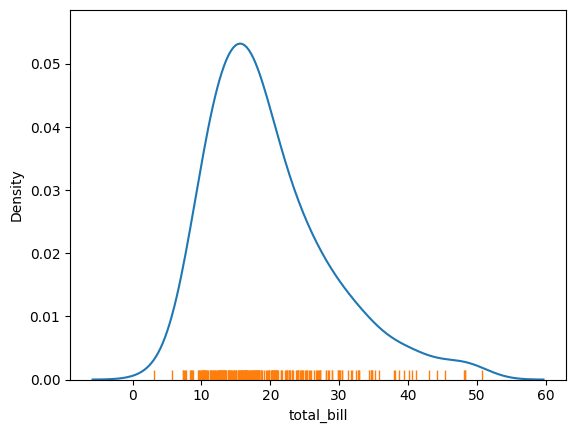

In [44]:
sns.kdeplot(data:tips, x:'total_bill')
sns.rugplot(data:tips, x:'total_bill')

scatterplotに重ねる。軸の外に高さを変えて表示する。

<AxesSubplot:xlabel='total_bill', ylabel='tip'>

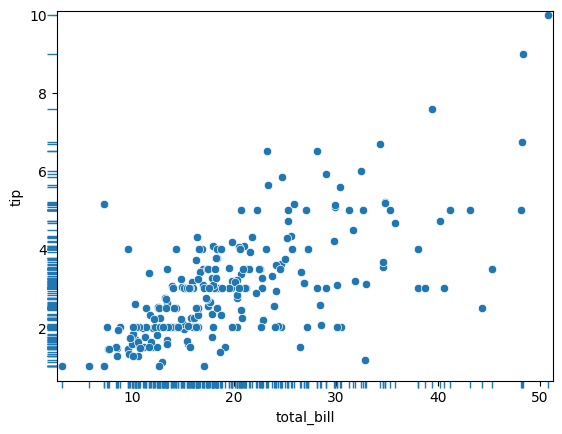

In [45]:
sns.scatterplot(data:tips, x:'total_bill', y:'tip')
sns.rugplot(data:tips, x:'total_bill', y:'tip', height:-0.02, clip_on:false)

### distplot (廃止)

dis**t**plot() は0.11.0で廃止、将来は削除される予定。後継は下記。
- histplot : axes-level function 
- displot : figure-level function 

### displot (Figure level)

分布表現用のFigure-level インターフェース

kind:"hist"(既定値)で histplot、kind:"kde"でkdeplot、kind:"ecdf"(1変数の場合のみ)でecdfplotとほぼ同等の機能を提供する。

[seaborn API reference: displot](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot)

1変数に対する分布の例。`kde:true`でKDEを重ねることもできる。

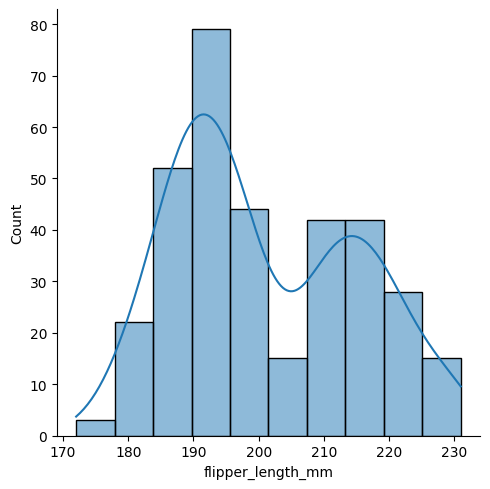

In [46]:
g = sns.displot(data:penguins, x:'flipper_length_mm', kde:true)

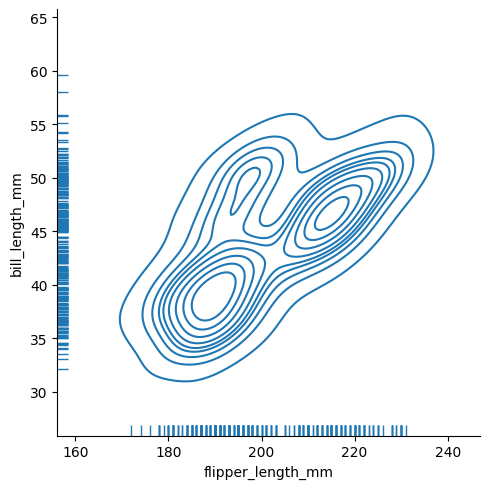

In [47]:
g = sns.displot(data:penguins, x:'flipper_length_mm', y:'bill_length_mm', kind:'kde', rug:true)

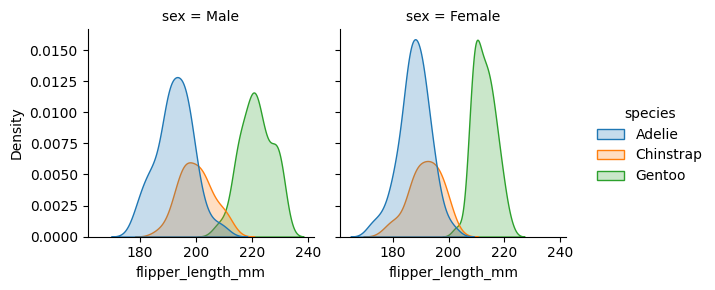

In [48]:
g = sns.displot(
  data:penguins,
  x:'flipper_length_mm', hue:'species', col:'sex',
  kind:'kde', fill:true,
  height:3,
)

#### displotチートシート

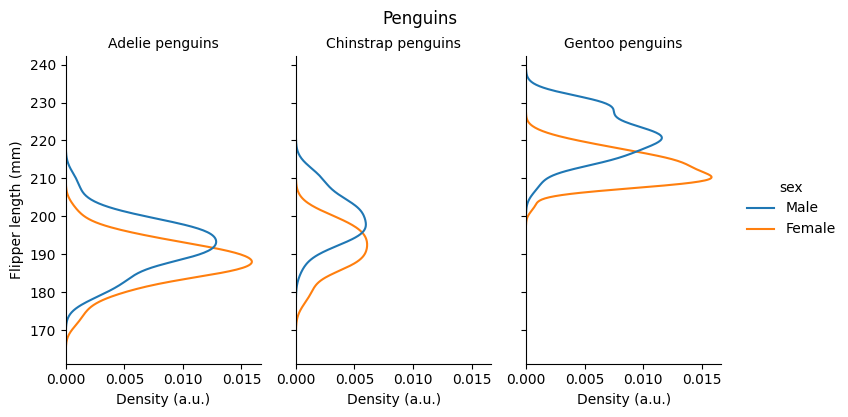

In [49]:
g = sns.displot(   # Figure-level interface for drawing distribution plots onto a FacetGrid
  data:penguins,    # pandas.DataFrame, numpy.ndarray, mapping, or sequence
  x:nil, y:'flipper_length_mm',   # vectors or keys in data
  col:'species', row:nil,    # vectors or keys in data
  col_wrap:nil,
  row_order:nil,col_order:nil,
  hue:'sex',        # vectors or keys in data
  kind:'kde',       # 'hist'(default), 'kde', 'ecdf'
  color:nil,
  palette:nil,      # sns.color_palette("Set2"), sns.color_palette('husl', int), etc.
  hue_order:nil, hue_norm:nil,
  rug:false, rug_kws:{},
  log_scale:false,
  legend:true,
  height:4, aspect:5/8.0,  # size of facet, aspect=width/height
  facet_kws:{},     # dict(sharex=False) : do not share x-axis
                    # dict(margin_titles=True) : place (col,row) title at top and left
)  # Returns FacetGrid
g.set_axis_labels('Density (a.u.)', 'Flipper length (mm)')
g.set_titles("{col_name} penguins")
g.fig.suptitle("Penguins", y: 1.03)   # Specify FacetGrid Title
g

## Categorical plots

### countplot

- カテゴリー別のアイテムの個数をバーで表すプロット。
- Axes level インターフェース
- [seaborn API reference: countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html#seaborn.countplot)

<AxesSubplot:xlabel='class', ylabel='count'>

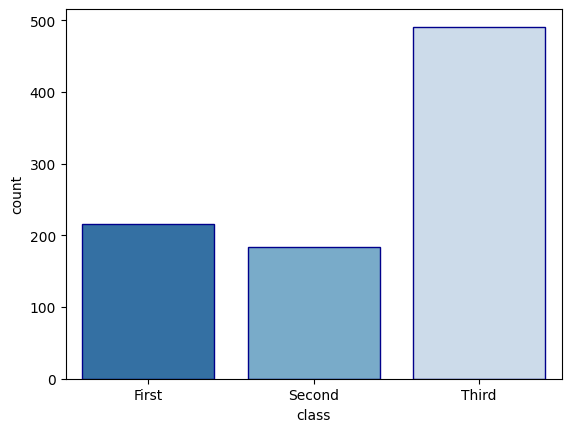

In [50]:
ax = sns.countplot(data:titanic, x:'class', palette:'Blues_r', edgecolor:'darkblue')

<AxesSubplot:xlabel='class', ylabel='count'>

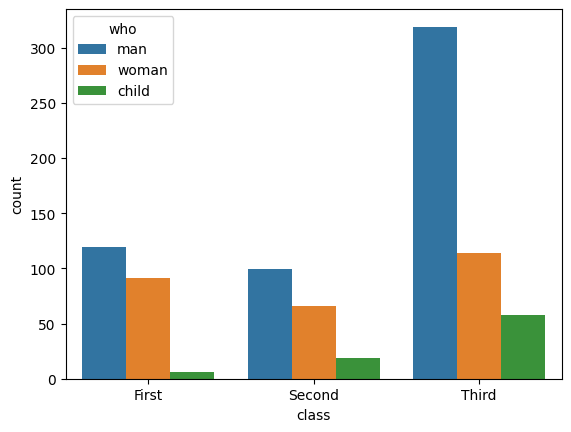

In [51]:
ax = sns.countplot(data:titanic, x:'class', hue:'who')

### barplot

- 信頼区間をバーに付加して表す
- Axes level インターフェース
- [seaborn API reference: barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html#seaborn.barplot)

<AxesSubplot:xlabel='day', ylabel='total_bill'>

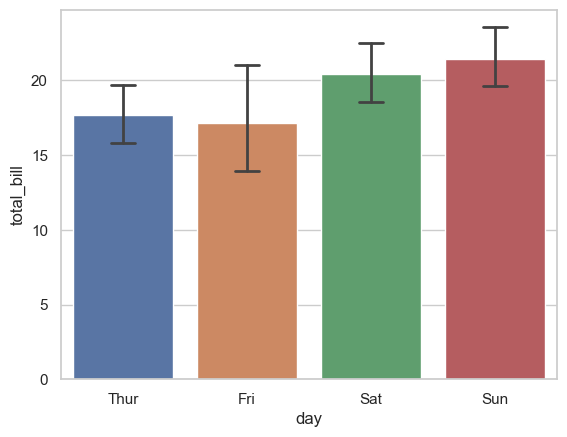

In [52]:
sns.set_theme(style:'whitegrid')
ax = sns.barplot(data:tips, x:'day', y:'total_bill', capsize:0.2, errwidth:2)

<AxesSubplot:xlabel='day', ylabel='total_bill'>

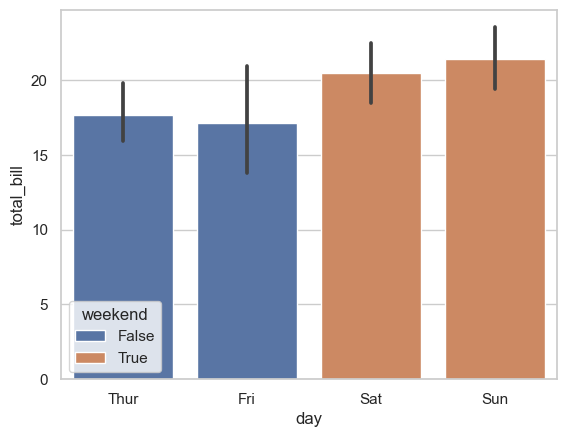

In [53]:
tips['weekend'] = tips['day'].isin(['Sat', 'Sun'])
ax = sns.barplot(data:tips, x:'day', y:'total_bill', hue:'weekend', dodge:false)

### pointplot

- 散布図に点の信頼区間を合わせて描くためのプロット
- Axes level インターフェース
- [seaborn API reference: pointplot](https://seaborn.pydata.org/generated/seaborn.pointplot.html#seaborn.pointplot)

<AxesSubplot:xlabel='solutions', ylabel='score'>

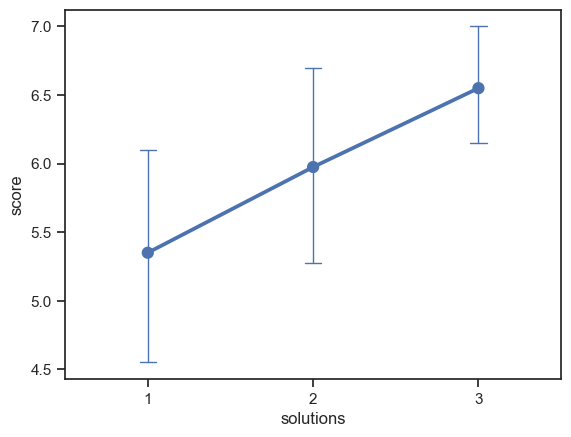

In [56]:
sns.set_theme(style:'ticks')
sns.pointplot(data:attention, x:'solutions', y:'score', order:[1,2,3], capsize:0.1, errwidth:1)

### boxplot

- 箱ひげ図
- Axes level インターフェース
- [seaborn API reference: boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html#seaborn.boxplot)

<AxesSubplot:xlabel='day', ylabel='total_bill'>

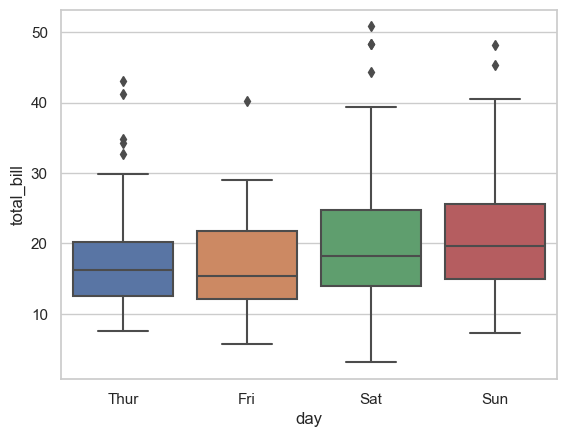

In [57]:
sns.set_theme(style:'whitegrid')
ax = sns.boxplot(data:tips, x:'day', y:'total_bill')

<AxesSubplot:xlabel='day', ylabel='total_bill'>

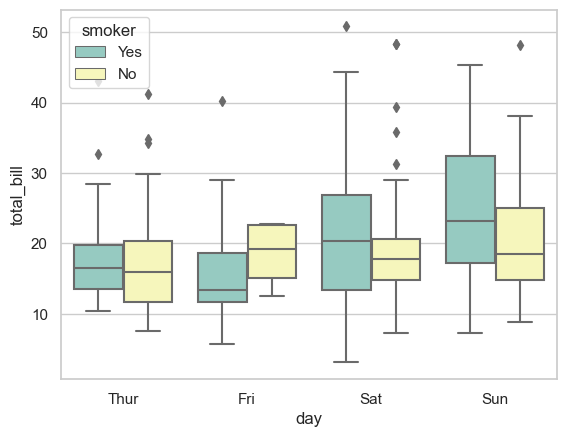

In [58]:
ax = sns.boxplot(data:tips, x:'day', y:'total_bill', hue:'smoker', palette:"Set3")

<AxesSubplot:>

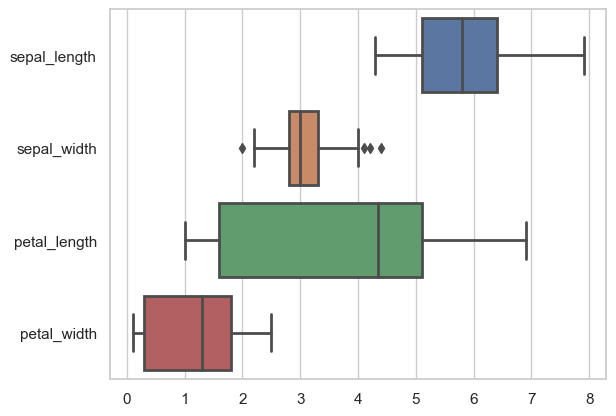

In [59]:
ax = sns.boxplot(data:iris, orient:'h', saturation:0.7, linewidth:2, whis:1.5)

### stripplot

- 1つのカテゴリー変数に対して散布図を描く
- Axes level インターフェース
- [seaborn API reference: stripplot](https://seaborn.pydata.org/generated/seaborn.stripplot.html#seaborn.stripplot)

<AxesSubplot:xlabel='day', ylabel='total_bill'>

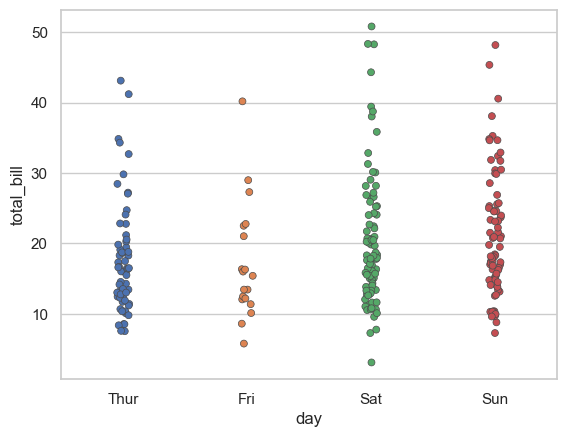

In [60]:
sns.set_theme(style:'whitegrid')
ax = sns.stripplot(data:tips, x:'day', y:'total_bill', jitter:0.05, linewidth:0.5)

<AxesSubplot:xlabel='day', ylabel='total_bill'>

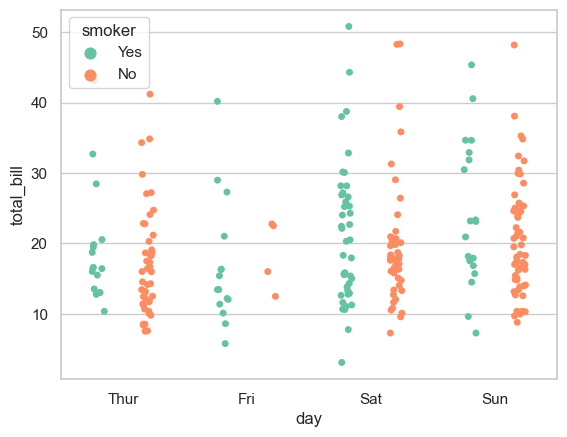

In [61]:
ax = sns.stripplot(data:tips, x:'day', y:'total_bill', hue:'smoker', palette:'Set2', dodge:true)

### swarmplot

- カテゴリー散布図を点が重ならないように描く
- Axes level インターフェース
- [seaborn API reference: swarmplot](https://seaborn.pydata.org/generated/seaborn.swarmplot.html#seaborn.swarmplot)

<AxesSubplot:xlabel='day', ylabel='total_bill'>

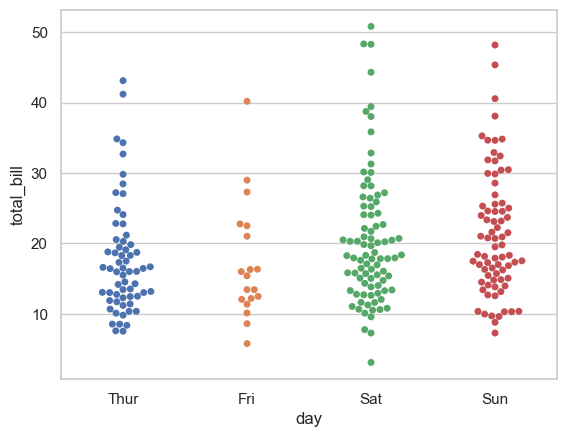

In [62]:
sns.set_theme(style:'whitegrid')
ax = sns.swarmplot(data:tips, x:'day', y:'total_bill')

<AxesSubplot:xlabel='day', ylabel='total_bill'>

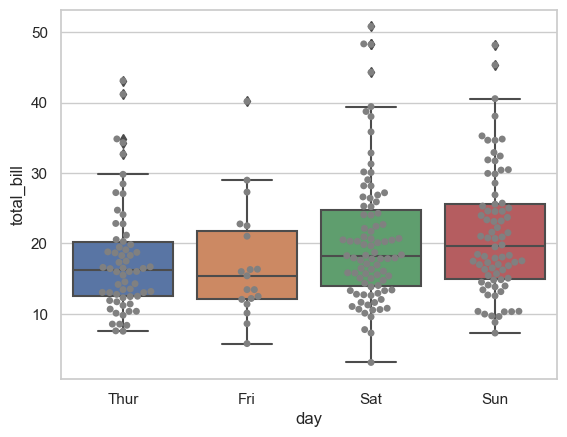

In [63]:
ax = sns.boxplot(data:tips, x:'day', y:'total_bill')
ax = sns.swarmplot(data:tips, x:'day', y:'total_bill', color:"0.5")

### boxenplot

- 大きなデータセット用の拡張された箱ひげプロット (https://vita.had.co.nz/papers/letter-value-plot.html)
- Axes level インターフェース
- [seaborn API reference: boxenplot](https://seaborn.pydata.org/generated/seaborn.boxenplot.html#seaborn.boxenplot)

<AxesSubplot:xlabel='day', ylabel='total_bill'>

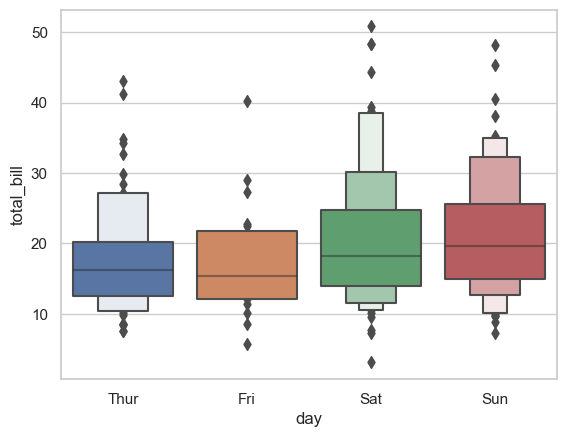

In [64]:
sns.set_theme(style:'whitegrid')
ax = sns.boxenplot(data:tips, x:'day', y:'total_bill')

<AxesSubplot:xlabel='day', ylabel='total_bill'>

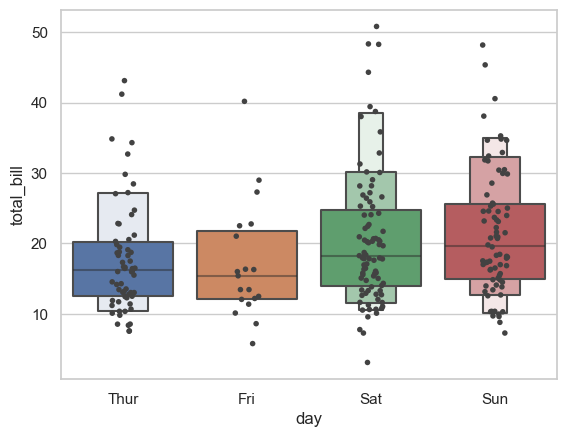

In [65]:
ax = sns.boxenplot(data:tips, x:'day', y:'total_bill',
                   showfliers:false)
ax = sns.stripplot(data:tips, x:'day', y:'total_bill',
                   size:4, color:".26")

### catplot (Figure level)

カテゴリープロットをFacetGridに描くためのFigure-levelインターフェース.

kind:'keyword'でプロットタイプを指定することができる

|name      |type         |kind:   |       |
|:---      |:---         |:---    |:---   | 
|stripplot |scatter      |'strip' |default|
|swarmplot |scatter      |'swarm' |       |
|boxplot   |distribution |'box'   |       |
|violinplot|distribution |'violin'|       |
|boxenplot |distribution |'boxen' |       |
|pointplot |estimate     |'point' |       |
|barplot   |estimate     |'bar'   |       |
|countplot |estimate     |'count' |       |


[seaborn API reference: catplot](https://seaborn.pydata.org/generated/seaborn.catplot.html#seaborn.catplot)

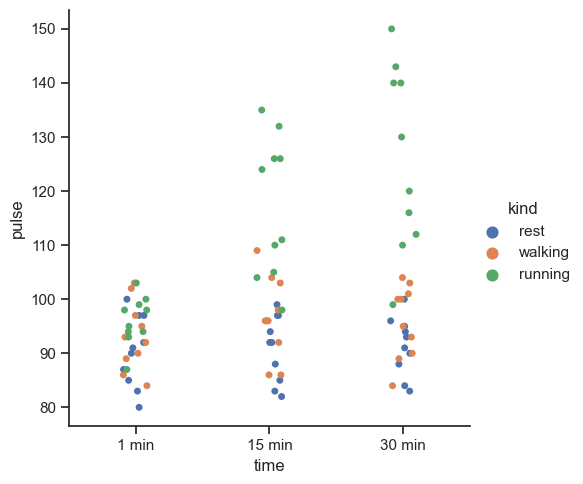

In [68]:
sns.set_theme(style:'ticks')
g = sns.catplot(data:exercise, x:'time', y:'pulse', hue:'kind')

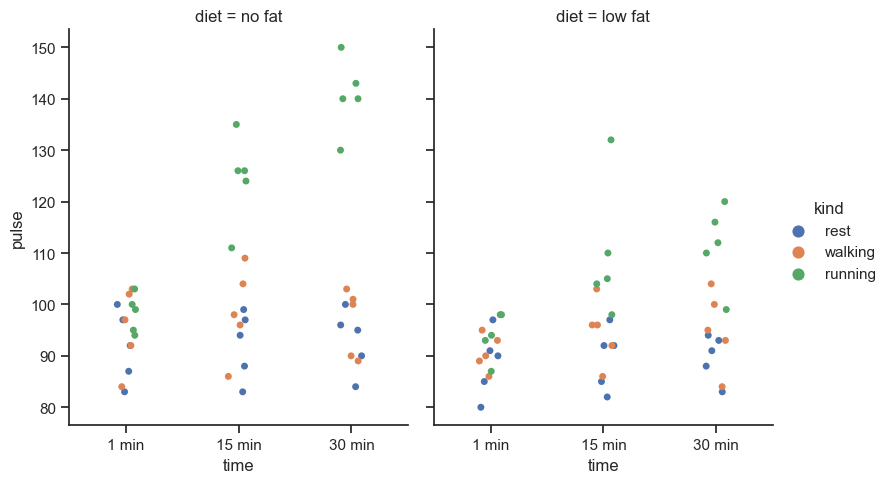

In [69]:
g = sns.catplot(data:exercise, x:'time', y:'pulse', hue:'kind', col:'diet', height:5, aspect:0.8)

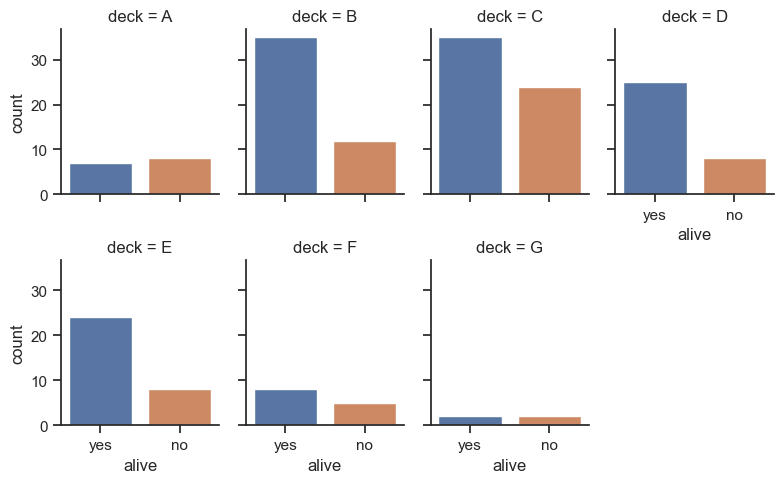

In [70]:
g = sns.catplot(
  data:titanic[titanic.deck.notnull],
  x:'alive',
  col:'deck', col_wrap:4,
  kind:'count',
  height:2.5, aspect:0.8,
)

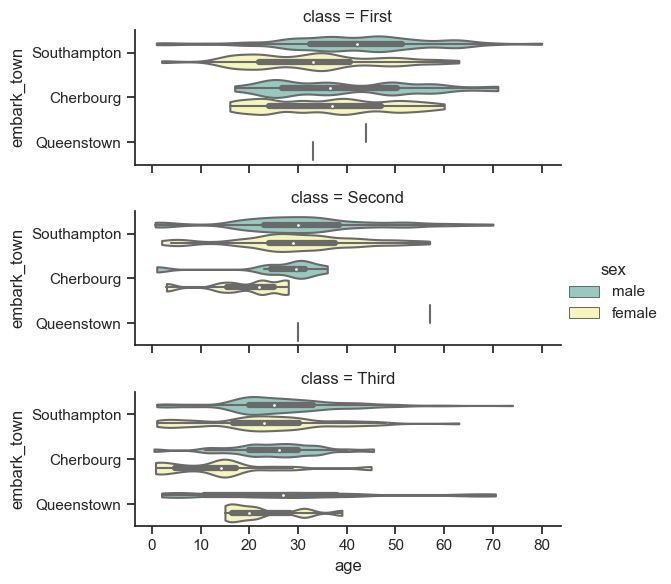

In [71]:
g = sns.catplot(
  data:titanic[titanic.embark_town.notnull],
  x:'age', y:'embark_town',
  hue:'sex',
  row:'class',
  kind:'violin',
  orient:'h',
  height:2, aspect:3,
  palette:'Set3',
  cut:0,
  bw:0.2,
)

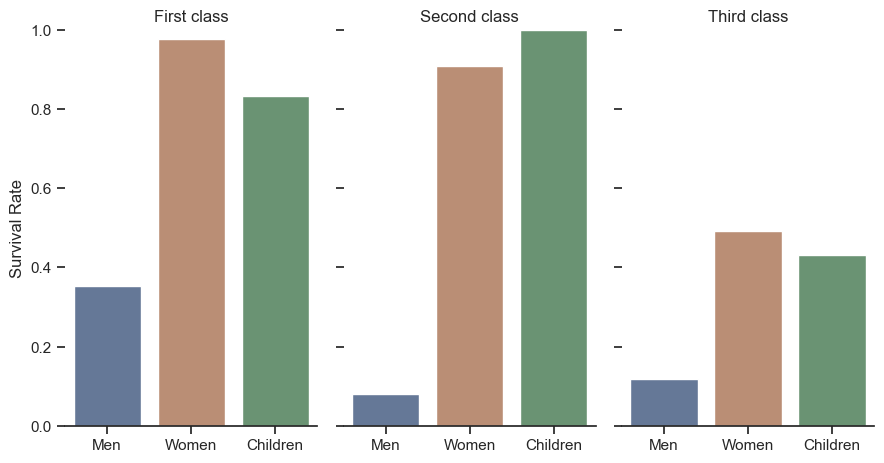

In [72]:
g = sns.catplot(
  data:titanic, kind:'bar',
  x:'who', y:'survived', col:'class',
  saturation:0.5,
  ci:nil, aspect:0.6,
).set_axis_labels("", "Survival Rate")
 .set_xticklabels(%w[Men Women Children])
 .set_titles("{col_name} {col_var}")
 .set(ylim:[0, 1])
 .despine(left:true)

#### catplotチートシート

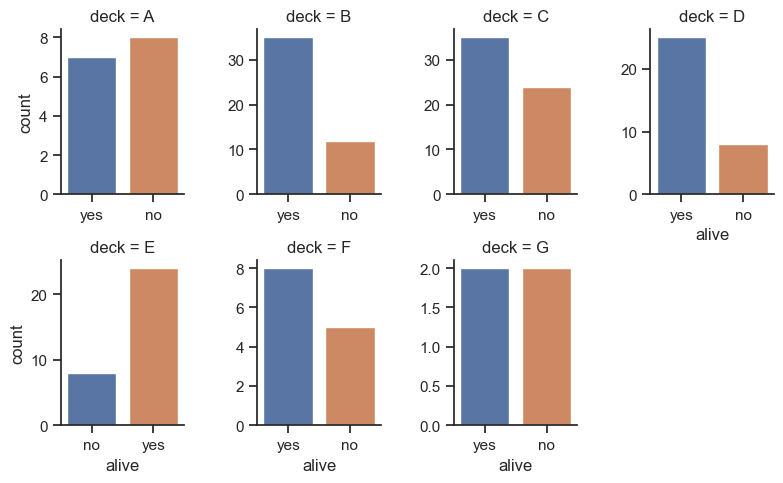

In [73]:
g = sns.catplot(  # Figure-level interface for drawing categorical plots onto a FacetGrid.
  data:titanic,   # Long-form (tidy) dataset with Column is variable, Row is observation.
  x:'alive', y:nil, hue:nil,  # names of variables in data input
  row:nil, col:'deck',        # names of categorical variables to determine grid, optional
  col_wrap:4,     # column width of the grid. Incompatible with a row facet.
  kind:'count',   # The kind of plot. Options are [strip, swarm, box, violin, boxen, point, bar, count].
  order:nil, hue_order:nil,  # Order to plot the categorical levels in, optional
  row_order:nil, col_order:nil, # Order to organize the rows and/or columns of the grid in, optional
  orient:'v',     # Orientation of the plot, ['v', 'h']
  sharex:nil, sharey:nil,  # If true, the facets will share y axes across columns and/or x axes across rows.
  height:2.5,     # Height (in inches) of each facet
  aspect:0.8,     # Aspect ratio of each facet. aspect=width/height
  legend:true,      # If true and there is a hue variable, draw a legend on the plot.
  legend_out:true,  # If true, the figure size will be extended, and the legend will be drawn outside the plot on the center right.
  color:nil,      # Color for all of the elements, or seed for a gradient palette.
  palette:nil,    # Color palette. sns.color_palette("Set2"), sns.color_palette('husl', int), etc.
  estimator:nil,  # Statistical function to estimate within each categorical bin. Optional.
  ci:95,          # Size of confidence intervals to draw. [float, 'sd', nil]
  n_boot:1000,    # Number of bootstrap iterations to use when computing confidence intervals.
  units:nil,      # name of variable in data or vector data, optional
  seed:nil,       # #Seed or random number generator, [int, numpy.random.Generator, numpy.random.RandomState], optional
  #margin_titles:nil,  # If true, the titles for the row variable are drawn to the right of the last column. Experimental.
  facet_kws:nil,  # Dictionary of other keyword arguments to pass to FacetGrid.
  #kwargs:nil,    # Other keyword arguments are passed through to the underlying plotting function.
) # Returns FacetGrid

## Regression plots

### regplot

- 回帰
- Axes level インターフェース
- [seaborn API reference: regplot](https://seaborn.pydata.org/generated/seaborn.regplot.html#seaborn.regplot)

<AxesSubplot:xlabel='total_bill', ylabel='tip'>

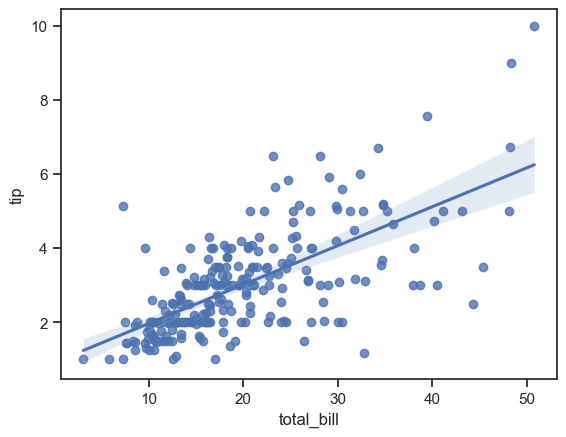

In [74]:
ax = sns.regplot(data:tips, x:'total_bill', y:'tip')

2次多項式による回帰

<AxesSubplot:xlabel='x', ylabel='y'>

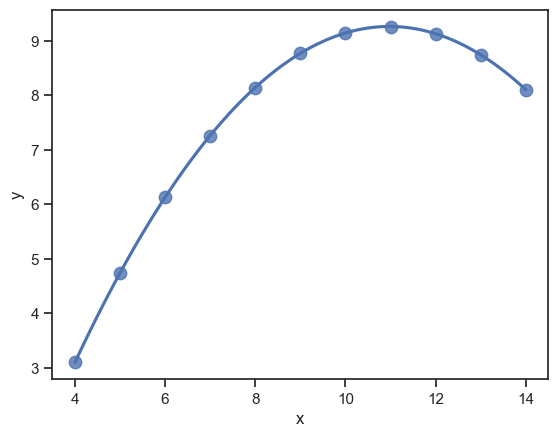

In [75]:
ax = sns.regplot(
  data:anscombe.loc[anscombe.dataset == 'II'],
  x:'x',
  y:'y',
  scatter_kws:{s:80},
  order:2,
  ci:nil,
)

Robustな回帰で、信頼区間を表示しない

<AxesSubplot:xlabel='x', ylabel='y'>

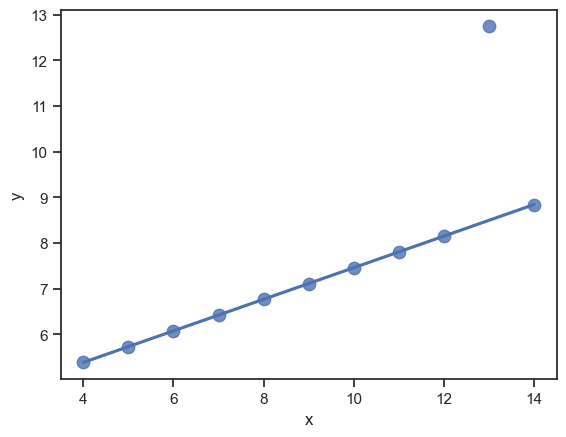

In [76]:
# robust:trueの場合 statsmodelsのインストールが必要(pip install statsmodels)
ax = sns.regplot(
  data: anscombe.loc[anscombe.dataset == 'III'],
  x:'x',
  y:'y',
  scatter_kws:{s:80},
  robust:true,
  ci:nil,
)

log(x)の回帰。`np.mean`はcallableなので、`PyCall.getattr(np, :mean)`で渡す。

<AxesSubplot:xlabel='size', ylabel='total_bill'>

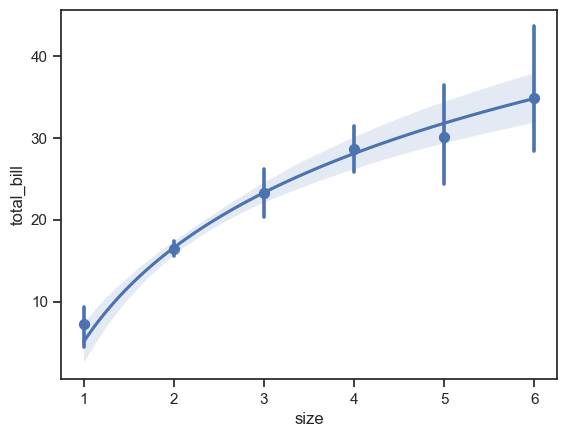

In [77]:
ax = sns.regplot(
    data:tips,
    x:'size', y:'total_bill',
    logx:true,
    x_estimator: PyCall.getattr(np, :mean), 
)

### lmplot (Figure level)
- `regplot`と`FacetGrid`を組み合わせた回帰プロット
- Figure level インターフェース
- [seaborn API reference: lmplot](https://seaborn.pydata.org/generated/seaborn.lmplot.html)

シンプルな直線回帰。`regplot`と同じ書き方だが、fig levelのオブジェクトが返されることに注意。

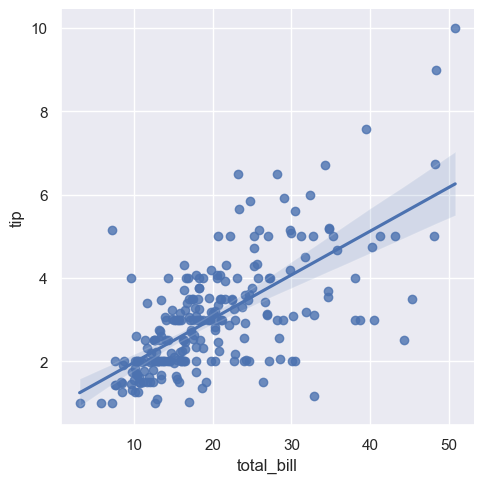

In [78]:
sns.set_theme(color_codes:true)
g = sns.lmplot(data:tips, x:'total_bill', y:'tip')

`regplot`と異なり、3つ目の変数をhueでプロットできる。

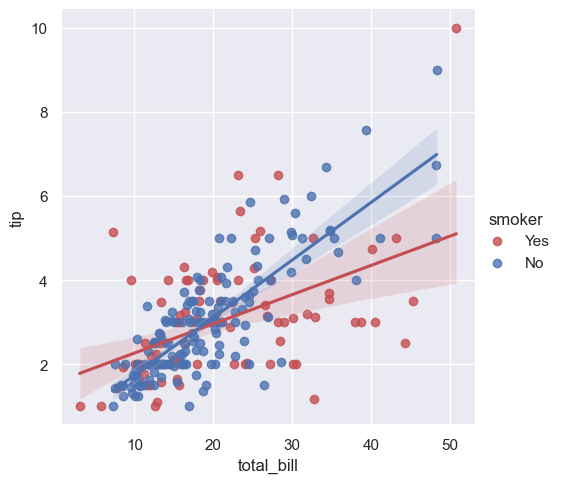

In [79]:
g = sns.lmplot(data:tips, x:'total_bill', y:'tip', hue:'smoker', palette:{Yes:"r", No:"b"})

3つ目の変数をcolでプロット。

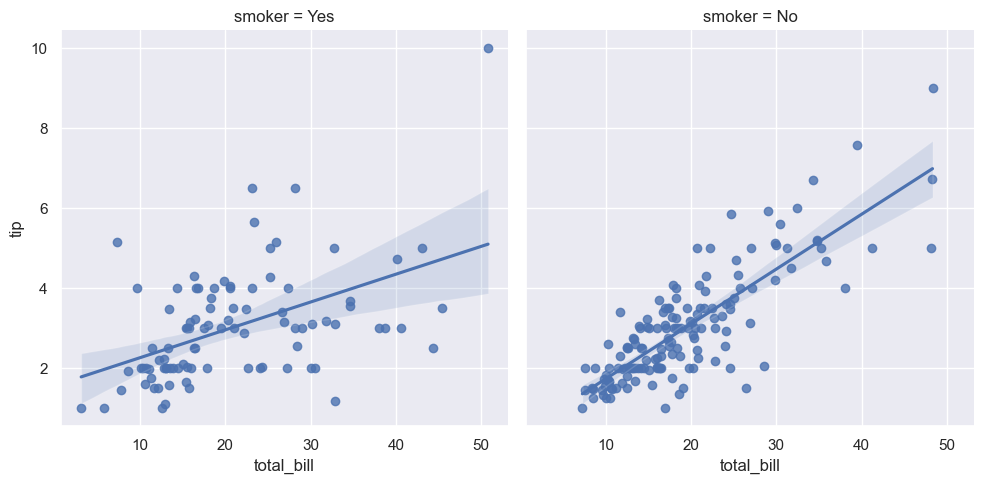

In [80]:
g = sns.lmplot(data:tips, x:'total_bill', y:'tip', col:'smoker')

4変数をgridで表現。さらに軸の調整を行う例。

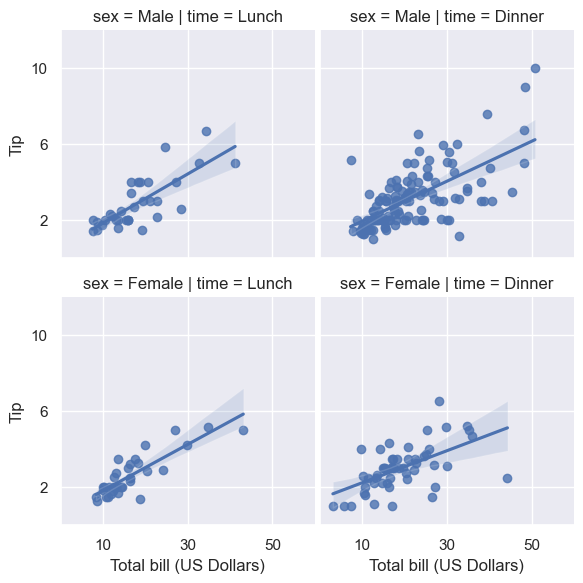

In [81]:
g = sns.lmplot(
  data:tips,
  x:'total_bill', y:'tip',
  row:'sex', col:'time',
  height:3,
).set_axis_labels(
  "Total bill (US Dollars)", "Tip"
).set(
  xlim:[0, 60], ylim:[0, 12],
  xticks:[10, 30, 50], yticks:[2, 6, 10]
).fig.subplots_adjust(wspace:0.02)
g

### residplot
- 残差を計算し`scatterplot`で表示する
- Axes level インターフェース
- [seaborn API reference: residplot](https://seaborn.pydata.org/generated/seaborn.residplot.html#seaborn.residplot)

<AxesSubplot:xlabel='total_bill', ylabel='tip'>

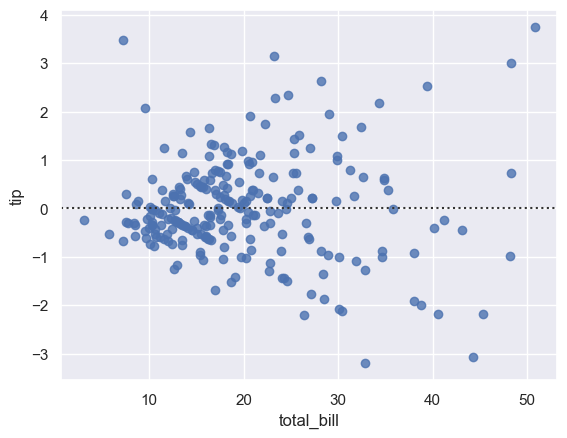

In [82]:
ax = sns.residplot(data:tips, x:'total_bill', y:'tip')

## Matrix plots

### heatmap
- 正方形状のデータをカラーマトリックスで表示する。
- Axes levelインターフェース
- [seaborn API reference: heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap)

ヒートマップを表示し、上限、下限を設定する例。

<AxesSubplot:>

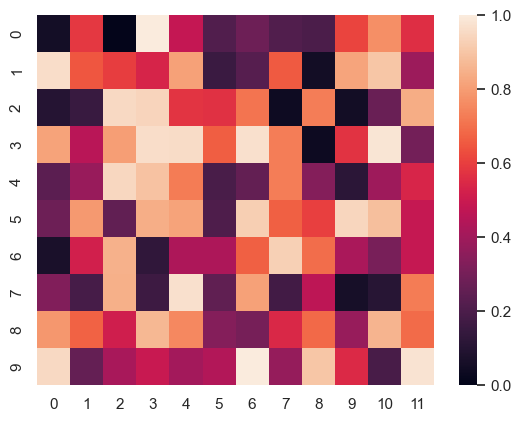

In [83]:
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(data:uniform_data, vmin:0, vmax:1)

数値を表示させ、さらに中央値を指定する例。

<AxesSubplot:xlabel='year', ylabel='month'>

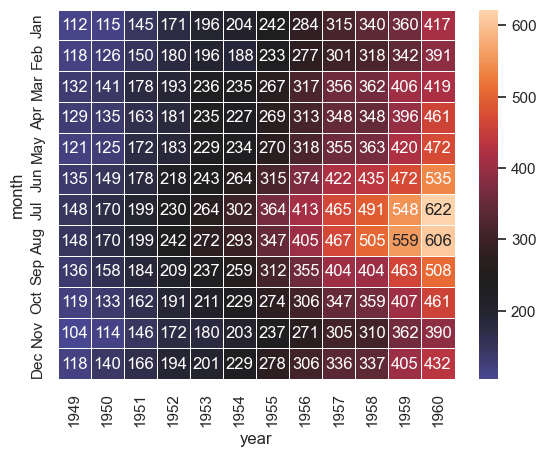

In [84]:
flights = sns.load_dataset('flights').pivot('month', 'year', 'passengers')
ax = sns.heatmap(
  data:flights,
  annot:true, fmt:'d', linewidths:0.5,
  center: flights.loc['Jan', 1955],
)

### clustermap
- クラスター化されたヒートマップを作成する
- `ClusterGrid`オブジェクトを返す
- [seaborn API reference: heatmap](https://seaborn.pydata.org/generated/seaborn.clustermap.html#seaborn.clustermap)

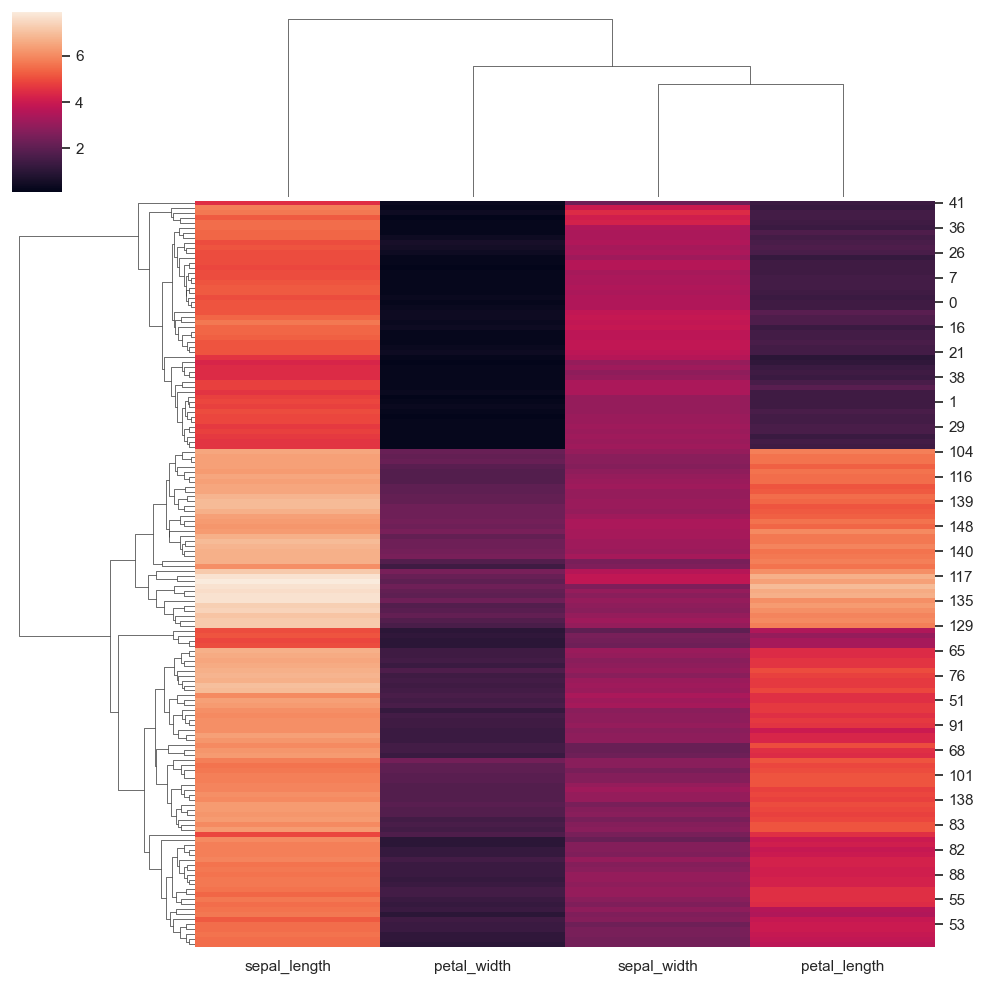

In [85]:
species = iris.pop('species')
g = sns.clustermap(iris)

## Multi-plot grids

### FacetGrid
- データセットを行(row)と列(col)からなるgridに配置して表現する
- matplotlibのfigureとFacetGridオブジェクトを生成する
- [seaborn API reference: FacetGrid](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html#seaborn.FacetGrid)

まず、FacetGridオブジェクトを作ってから、中身をプロットするオブジェクトをcallableで割り当てます。

Pythonで`sns.FacetGrid(tips, ...`と書くところ(constructor)は、pycall.rbでは`sns.FacetGrid.new(tips, ...`と書きます。

Pythonでは`sns.scatterplot`が引数の中のcallableですが、pycall.rbでは`PyCall.getaddr(sns, :scatterplot)`と書く必要があります。[(参考)](https://github.com/mrkn/pycall.rb#the-callable-attribute-of-an-object)

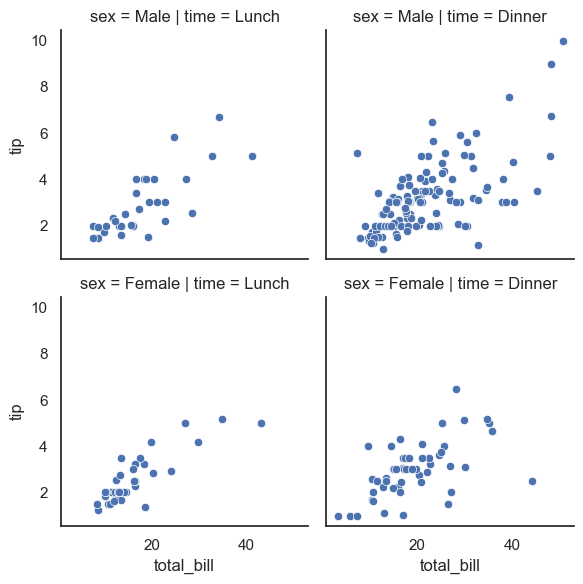

In [86]:
sns.set_theme(style:'white')
g = sns.FacetGrid.new(data:tips, col:'time', row:'sex')
scatterplot = PyCall.getattr(sns, :scatterplot)  # callable
g.map(scatterplot, 'total_bill', 'tip')  # FacetGrid.mapではkeyword argが使えない?

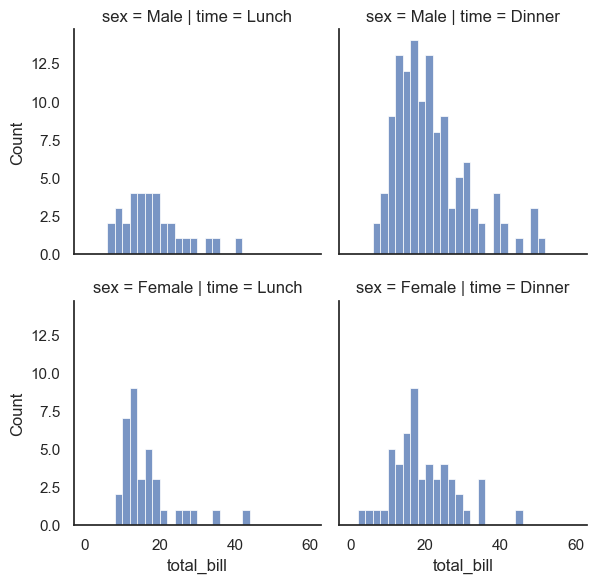

In [87]:
g = sns.FacetGrid.new(tips, col:'time', row:'sex')
histplot = PyCall.getattr(sns, :histplot)
g.map_dataframe(func:histplot, x:'total_bill', binwidth:2, binrange:[0, 60])

`hue`をFacetGridの生成時に指定するやり方。

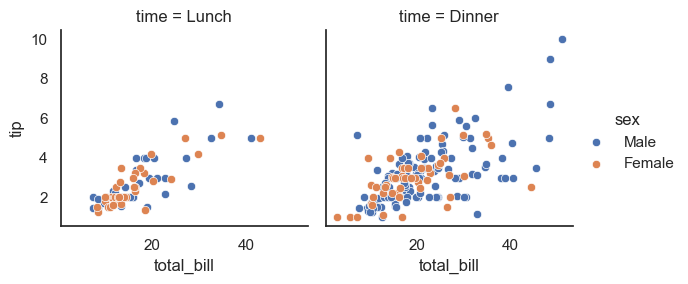

In [88]:
g = sns.FacetGrid.new(data:tips, col:'time', hue:'sex')
g.map_dataframe(func:scatterplot, x:'total_bill', y:'tip')
g.add_legend

`hue`をmap時にaxes func側で指定するやり方。

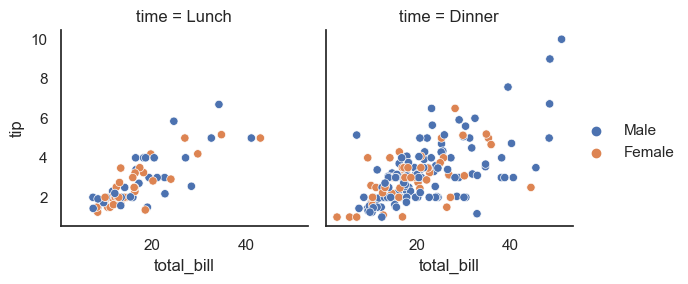

In [89]:
g = sns.FacetGrid.(data:tips, col:'time')
g.map_dataframe(scatterplot, x:'total_bill', y:'tip', hue:'sex')
g.add_legend()

列が多い場合は`col_wrap`で折り返すことができる。

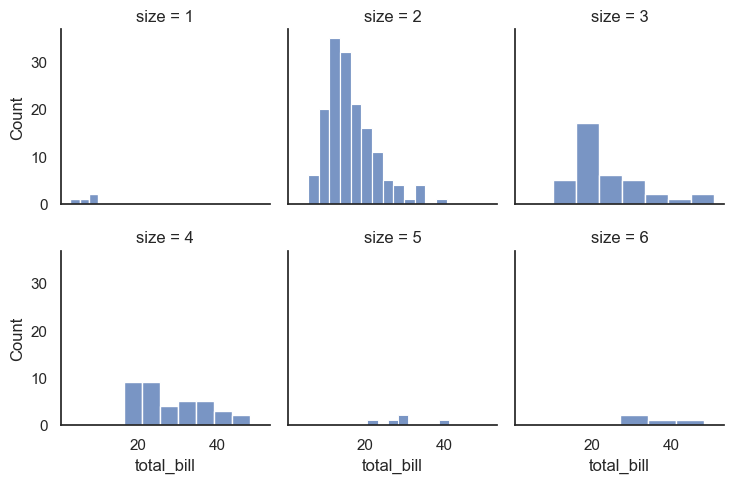

In [90]:
g = sns.FacetGrid.new(data:tips, col:'size', height:2.5, col_wrap:3)
g.map(histplot, 'total_bill')

`FacetGrid.refline`で水平線を追加する。

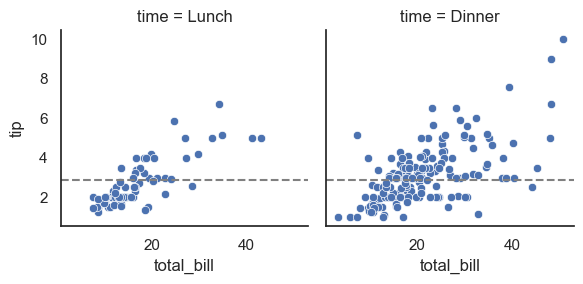

In [91]:
g = sns.FacetGrid.new(data:tips, col:'time', margin_titles:true)
g.map_dataframe(func:scatterplot, x:'total_bill', y:'tip')
g.refline(y: tips.tip.median)

カスタムfuncでプロットすることもできます。

In [92]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


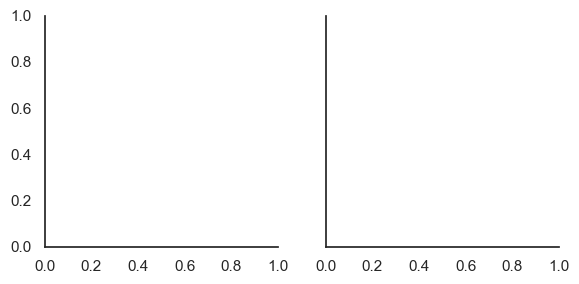

In [93]:
g = sns.FacetGrid.new(data:tips, col:'time')

#g.map_dataframe(sns.scatterplot, x:'total_bill', y:'tip')

=begin
def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.text(.1, .6, f"N = {n}", transform=ax.transAxes)
g.map_dataframe(annotate)
=end

その他のカスタマイズ例。`axes_dict`は`(row, col)`をキーとした辞書で対応するaxesを返す。

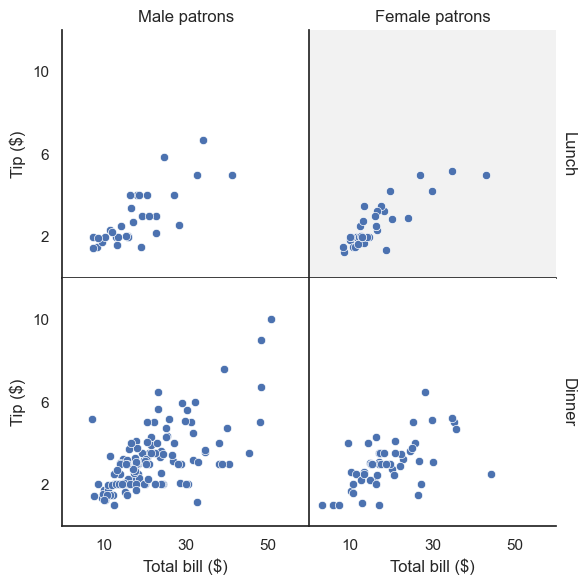

In [94]:
g = sns.FacetGrid.new(data:tips, col:'sex', row:'time', margin_titles:true)
g.map_dataframe(scatterplot, x:'total_bill', y:'tip')
#g.tight_layout
g.figure.subplots_adjust(wspace:0, hspace:0)
g.set_axis_labels("Total bill ($)", "Tip ($)")
g.set_titles(col_template:"{col_name} patrons", row_template:"{row_name}")
g.set(xlim:[0, 60], ylim:[0, 12], xticks:[10, 30, 50], yticks:[2, 6, 10])
g.axes_dict[PyCall::Tuple.new('Lunch', 'Female')].set_facecolor(".95")
g.savefig("facet_plot.png")

### pairplot
- データセットの中のペアごとの相関を表現する。
- PairGridオブジェクトを返す
- [seaborn API reference: pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn.pairplot)

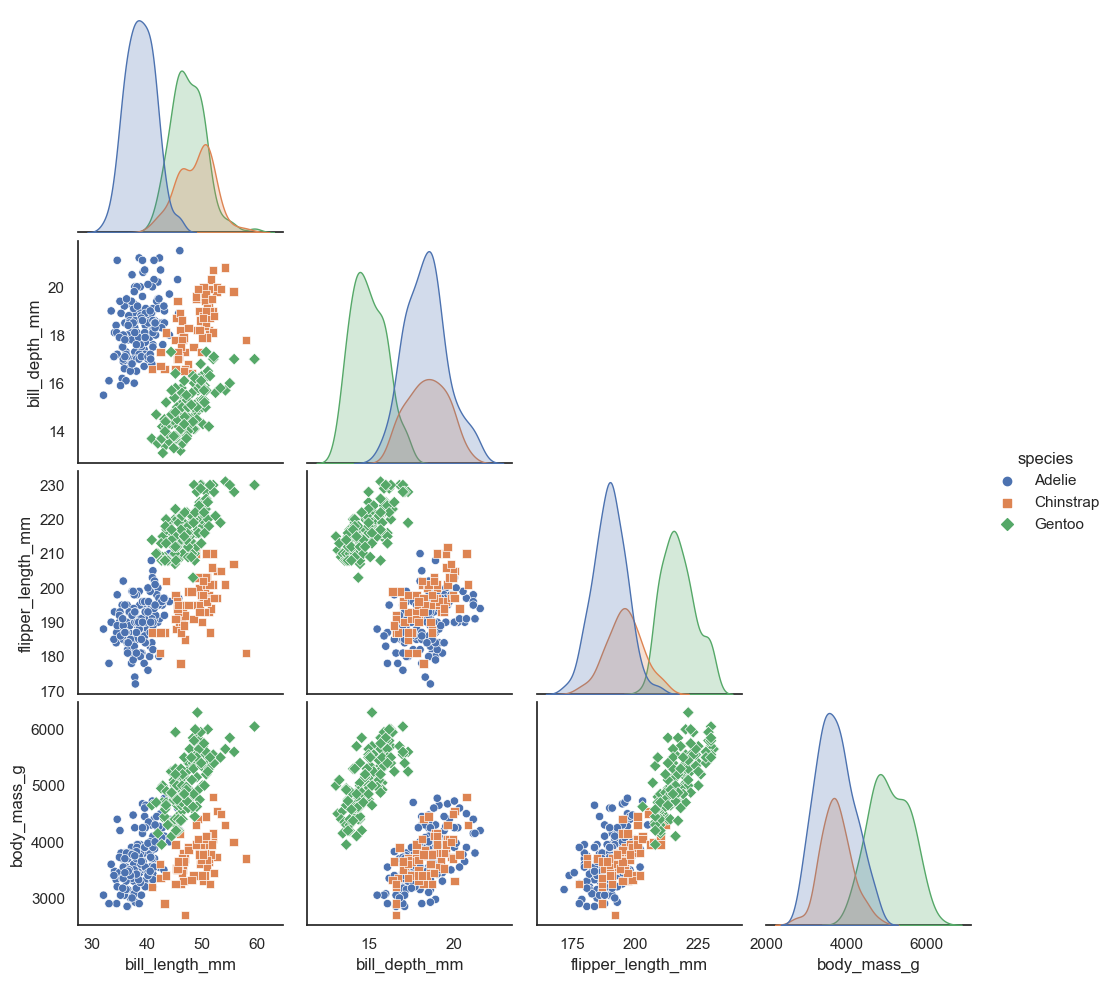

In [95]:
sns.pairplot(data:penguins, hue:'species', markers:%w[o s D], corner:true)

### PairGrid
- データセットの中のペアごとの相関を表現する。
- PairGridオブジェクトを生成する
- [seaborn API reference: PairGrid](https://seaborn.pydata.org/generated/seaborn.PairGrid.html#seaborn.PairGrid)

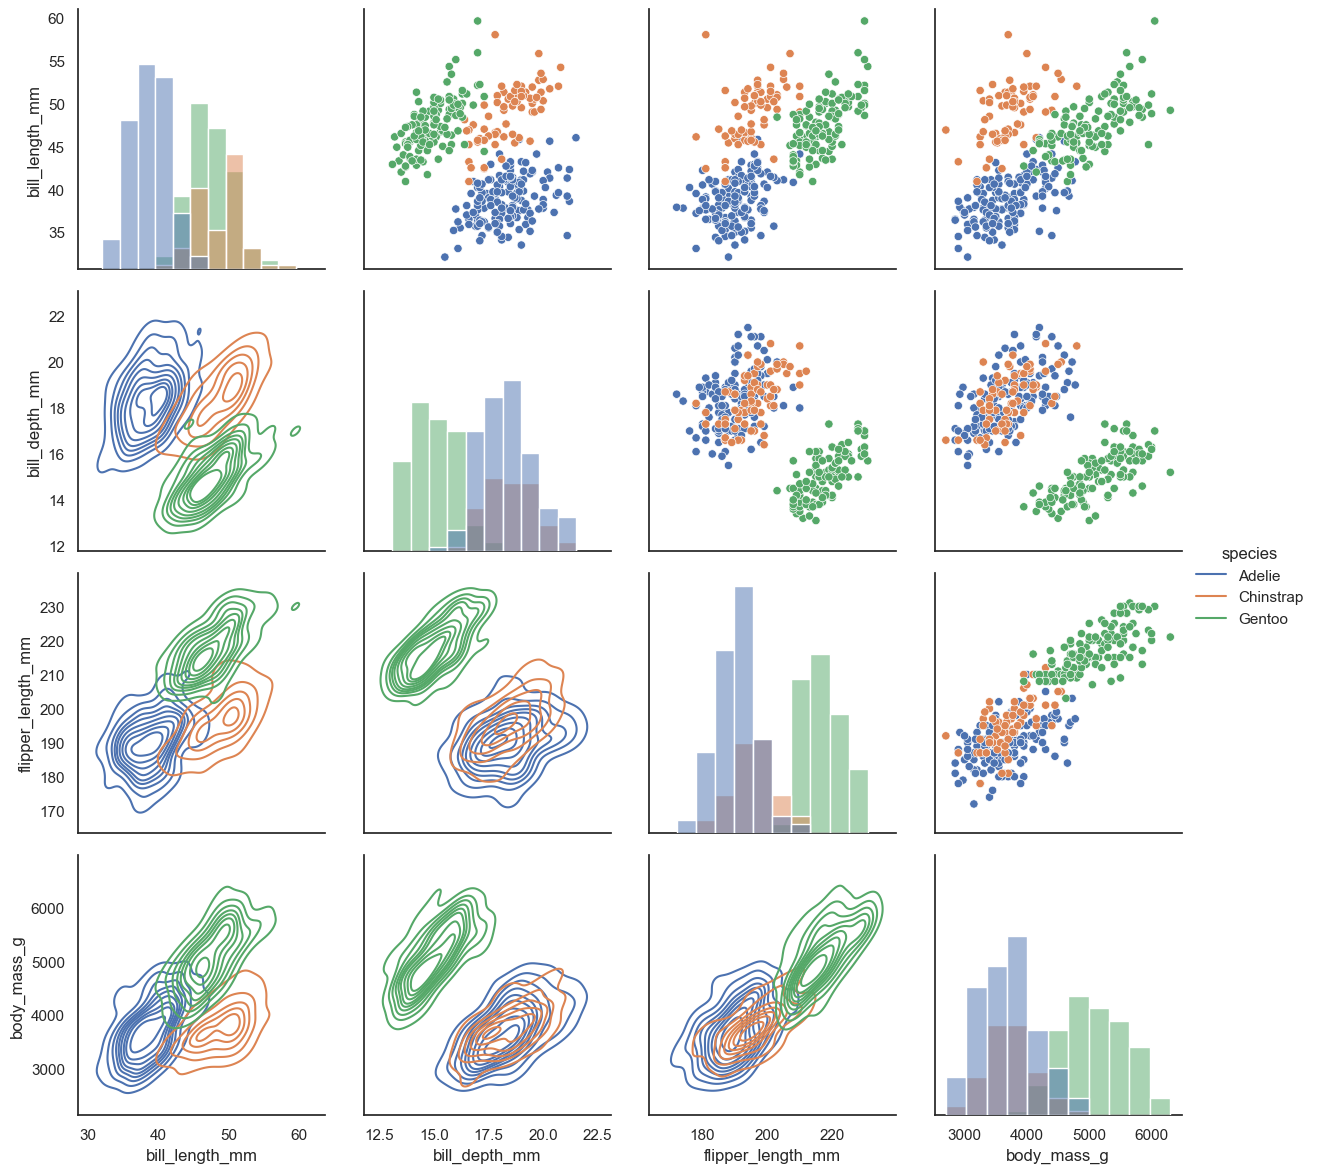

In [96]:
g = sns.PairGrid.new(data:penguins, hue:'species', height:3)
g.map_diag(PyCall.getattr(sns, :histplot))
g.map_upper(PyCall.getattr(sns, :scatterplot))
g.map_lower(PyCall.getattr(sns, :kdeplot))
g.add_legend

### jointplot
- 二変数グラフと一変数のグラフを組み合わせて表示する
- JointGridの簡易版。JointGridオブジェクトを返す。
- [seaborn API reference: jointplot](https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot)

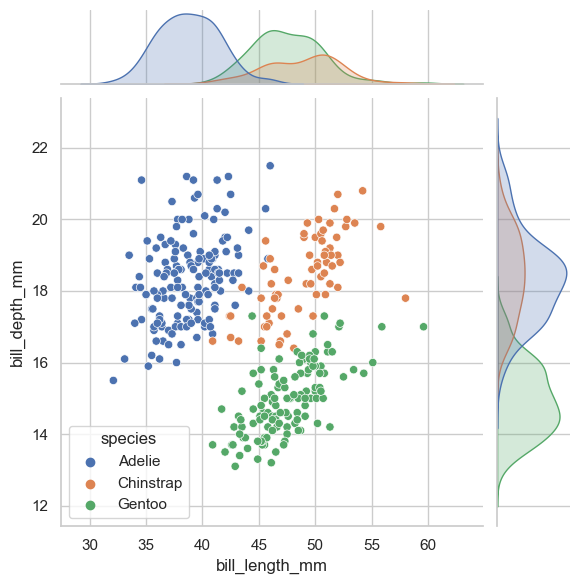

In [97]:
sns.set_theme(style:'whitegrid')
g = sns.jointplot(data:penguins, x:'bill_length_mm', y:'bill_depth_mm', hue:'species')

### JointGrid
- 二変数グラフと一変数のグラフを組み合わせて表示する
- 自由度が高い。JointGridオブジェクトを生成する。
- [seaborn API reference: JointGrid](https://seaborn.pydata.org/generated/seaborn.JointGrid.html#seaborn.JointGrid)

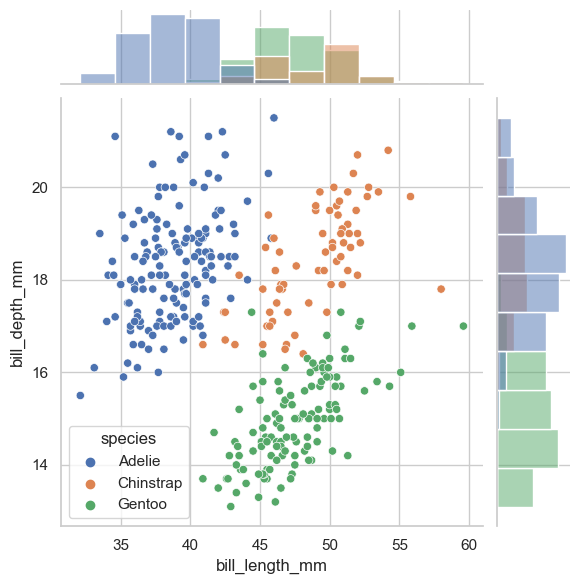

In [98]:
g = sns.JointGrid.new(data:penguins, x:'bill_length_mm', y:'bill_depth_mm', hue:'species')
scatterplot = PyCall.getattr(sns, :scatterplot)
histplot = PyCall.getattr(sns, :histplot)
g.plot(scatterplot, histplot)

## テーマ

### default

<AxesSubplot:>

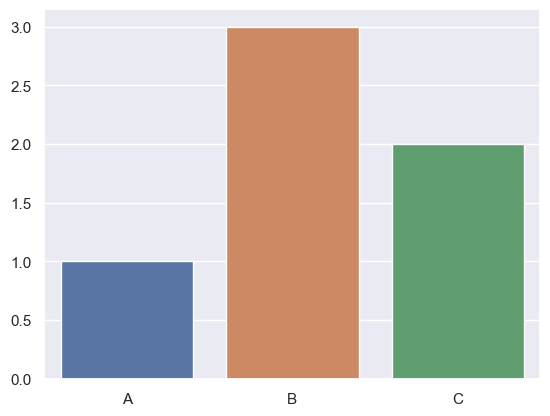

In [99]:
sns.set_theme()
sns.barplot(x:["A", "B", "C"], y:[1, 3, 2])

### whitegrid

<AxesSubplot:>

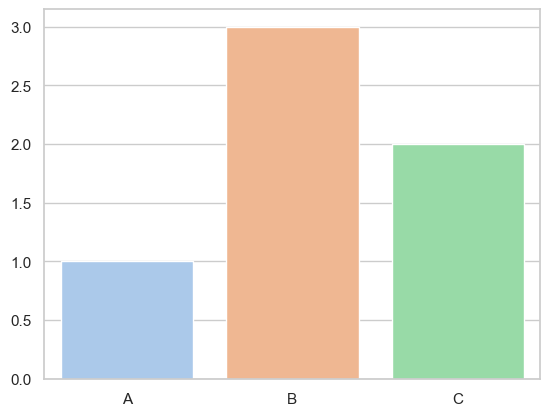

In [100]:
sns.set_theme(style:'whitegrid', palette:'pastel')
sns.barplot(x:["A", "B", "C"], y:[1, 3, 2])

### white

<AxesSubplot:>

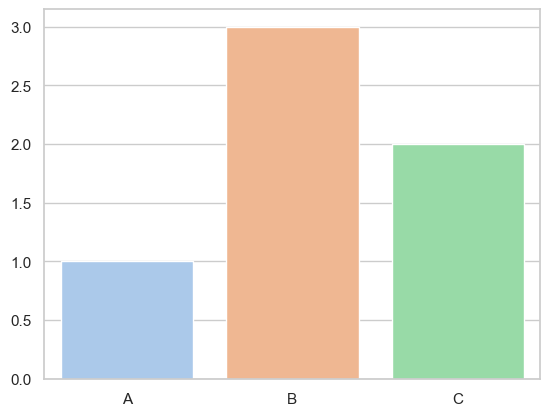

In [101]:
sns.set_theme(style:'whitegrid', palette:nil)
sns.barplot(x:["A", "B", "C"], y:[1, 3, 2])

### ticks

<AxesSubplot:>

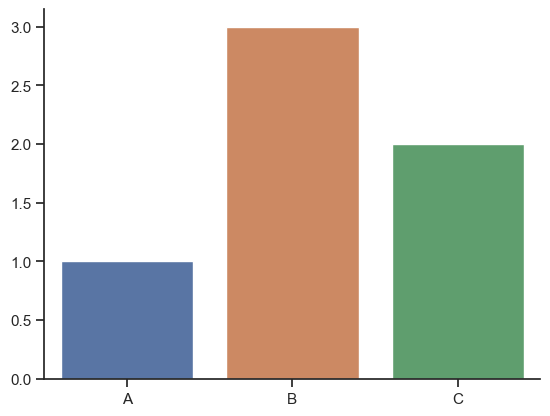

In [102]:
custom_params = {"axes.spines.right": false, "axes.spines.top": false}
sns.set_theme(style:'ticks', rc:custom_params)
sns.barplot(x:["A", "B", "C"], y:[1, 3, 2])